# Linear Optimization

Optimizes a linear straight-line path from a point on the viable brain surface region to a point on the subthalamic nucleus (STN) for DBS electrode planning.

Treats the following as obstacles:
- Sulci
- Ventricles
- Corpus Callosum (prevent brain crossing)

**Objective Functions**
- Distance to obstacles
- Minimum path distance  *(not optimized yet)*

## 1. Setup

### Import Libraries

In [1]:
import os
import glob
import random
import numpy as np

import vedo
from vedo import Volume, show, Line, merge, Plotter

from scipy.optimize import minimize

import k3d

In [2]:
# Set vedo backend to pop out plots in separate windows
vedo.settings.default_backend = '2d' # or 'vt' or '2d' or 'k3d' or 'ipyvtklink'

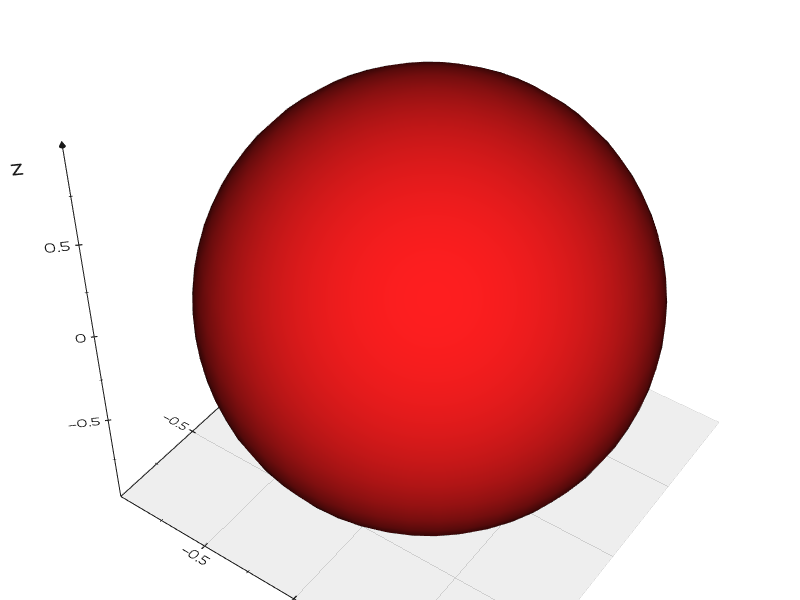

In [3]:
## Vedo sphere plot test
sphere = vedo.Sphere(pos=[0, 0, 0], c="red", r=1.0)
plotter = vedo.Plotter()
plotter += sphere
plotter.show(axes=1, viewup='z', zoom=1.5)


### Configuration and Setup

In [4]:
# Define new base directory and sub-folder structure
base_dir = "./FINAL_BRAIN_ATLAS/final_nii_files"

# Entry zones (viable surface regions for path start)
entry_zone_dir = os.path.join(base_dir, "entry_zone")
left_entry_zone_dir = os.path.join(entry_zone_dir, "LEFT_ENTRY_ZONE")
right_entry_zone_dir = os.path.join(entry_zone_dir, "RIGHT_ENTRY_ZONE")

# Subthalamic nucleus (targets)
stn_root_dir = os.path.join(base_dir, "subthalamic_nucleus")
left_stn_dir = os.path.join(stn_root_dir, "LEFT_STN")
right_stn_dir = os.path.join(stn_root_dir, "RIGHT_STN")

# Full brain (for context / outline only)
full_brain_dir = os.path.join(base_dir, "full_brain")

# Skin surface (outer head/skin/skull)
skin_dir = os.path.join(base_dir, "skin")

# Obstacles (same role as before)
obstacles_dir = os.path.join(base_dir, "obstacles")

print("Base directory:", base_dir)


Base directory: ./FINAL_BRAIN_ATLAS/final_nii_files


### Load Brain Structures

Recursively load all `.nii` / `.nii.gz` files under each designated root:
- Entry Zones (LEFT/RIGHT) viable start regions (light brown, low alpha)
- STN Targets (LEFT/RIGHT) (distinct greens)
- Obstacles (red)
- Full Brain outline (very light grey, minimal alpha)

All subfolder contents are merged later per category.

In [5]:
# Initialize lists for different structure types
left_entry_zone_structures = []
right_entry_zone_structures = []
left_stn_structures = []
right_stn_structures = []
allowed_left_entry_zone_structures = []
allowed_right_entry_zone_structures = []
obstacle_structures = []
full_brain_structures = []
skin_structures = []

# Loader utility: walk all subfolders and load every .nii / .nii.gz
def load_folder_surfaces(root_folder, color, alpha=1.0):
    loaded = []
    if not os.path.isdir(root_folder):
        print(f"[WARN] Folder not found: {root_folder}")
        return loaded
    
    for dirpath, dirnames, filenames in os.walk(root_folder):
        nii_files = [f for f in filenames if f.lower().endswith('.nii') or f.lower().endswith('.nii.gz')]
        for fname in nii_files:
            fpath = os.path.join(dirpath, fname)
            rel = os.path.relpath(fpath, root_folder)
            print(f"  Loading structure: {rel}")
            try:
                vol = Volume(fpath)
                surf = vol.isosurface()
                surf.c(color).alpha(alpha)
                loaded.append(surf)
            except Exception as e:
                print(f"  [WARN] Failed to load volume/surface: {fpath} ({e})")
    if not loaded:
        print(f"  [INFO] No NIfTI files found under {root_folder}")
    return loaded

print("\nLoading Entry Zones (LEFT)...")
left_entry_zone_structures = load_folder_surfaces(left_entry_zone_dir, color=(0.95, 0.65, 0.85), alpha=0.04)
print("Loading Entry Zones (RIGHT)...")
right_entry_zone_structures = load_folder_surfaces(right_entry_zone_dir, color=(0.95, 0.75, 0.85), alpha=0.04)

# STN folders (may already be deepest; recursion still safe)
print("\nLoading STN (LEFT)...")
left_stn_structures = load_folder_surfaces(left_stn_dir, color="green", alpha=1.0)
print("Loading STN (RIGHT)...")
right_stn_structures = load_folder_surfaces(right_stn_dir, color="green", alpha=1.0)

print("\nLoading Obstacles...")
obstacle_structures = load_folder_surfaces(obstacles_dir, color="red", alpha=0.7)

print("\nLoading Full Brain Outline...")
full_brain_structures = load_folder_surfaces(full_brain_dir, color="grey", alpha=0.01)

print("\nLoading Skin Surface...")
# Use light skin tone color and slightly higher alpha for visibility
skin_structures = load_folder_surfaces(skin_dir, color="grey", alpha=0.02)



Loading Entry Zones (LEFT)...
  Loading structure: LEFT_FRONTAL_LOBE\Model_1003_posterior_part_of_left_middle_frontal_gyrus.nii
  Loading structure: LEFT_FRONTAL_LOBE\Model_1012_left_lateral_orbital_gyrus.nii  Loading structure: LEFT_FRONTAL_LOBE\Model_1012_left_lateral_orbital_gyrus.nii
  Loading structure: LEFT_FRONTAL_LOBE\Model_1014_left_straight_gyrus.nii
  Loading structure: LEFT_FRONTAL_LOBE\Model_1017_left_paracentral_lobule.nii
  Loading structure: LEFT_FRONTAL_LOBE\Model_1018_opercular_part_of_left_inferior_frontal_gyrus.nii
  Loading structure: LEFT_FRONTAL_LOBE\Model_1019_orbital_part_of_left_inferior_frontal_gyrus.nii
  Loading structure: LEFT_FRONTAL_LOBE\Model_1020_triangular_part_of_left_inferior_frontal_gyrus.nii
  Loading structure: LEFT_FRONTAL_LOBE\Model_1024_left_precentral_gyrus.nii
  Loading structure: LEFT_FRONTAL_LOBE\Model_1027_anterior_part_of_left_middle_frontal_gyrus.nii
  Loading structure: LEFT_FRONTAL_LOBE\Model_1028_left_superior_frontal_gyrus.nii
  Lo

### Merge Structures

Combine individual structures into single meshes for:
- LEFT/RIGHT Entry Zones (start sampling)
- LEFT/RIGHT STN (target sampling hemisphere-consistent)
- Obstacles (for intersection & distance)
- Full Brain (context outline only)


In [6]:
# Merge structures into single meshes
merged_left_entry_zone = merge(left_entry_zone_structures) if left_entry_zone_structures else None
if merged_left_entry_zone: merged_left_entry_zone.alpha(0.04)

merged_right_entry_zone = merge(right_entry_zone_structures) if right_entry_zone_structures else None
if merged_right_entry_zone: merged_right_entry_zone.alpha(0.04)

merged_allowed_left_entry_zone = merged_left_entry_zone
merged_allowed_right_entry_zone = merged_right_entry_zone

merged_left_stn = merge(left_stn_structures) if left_stn_structures else None
merged_right_stn = merge(right_stn_structures) if right_stn_structures else None

merged_obstacles = merge(obstacle_structures) if obstacle_structures else None
if merged_obstacles: merged_obstacles.c("red").alpha(0.75)

merged_full_brain = merge(full_brain_structures) if full_brain_structures else None
if merged_full_brain: merged_full_brain.c("grey").alpha(0.01)

merged_skin = merge(skin_structures) if skin_structures else None
if merged_skin: merged_skin.c("grey").alpha(0.02)

print("\nMerged Summary:")
print(f"  Left Entry Zone: {'yes' if merged_left_entry_zone else 'no'}")
print(f"  Right Entry Zone: {'yes' if merged_right_entry_zone else 'no'}")
print(f"  Left Allowed Entry Zone: {'yes' if merged_allowed_left_entry_zone else 'no'}")
print(f"  Right Allowed Entry Zone: {'yes' if merged_allowed_right_entry_zone else 'no'}")
print(f"  Left STN: {'yes' if merged_left_stn else 'no'}")
print(f"  Right STN: {'yes' if merged_right_stn else 'no'}")
print(f"  Obstacles: {'yes' if merged_obstacles else 'no'}")
print(f"  Full Brain: {'yes' if merged_full_brain else 'no'}")
print(f"  Skin: {'yes' if merged_skin else 'no'}")



Merged Summary:
  Left Entry Zone: yes
  Right Entry Zone: yes
  Left Allowed Entry Zone: yes
  Right Allowed Entry Zone: yes
  Left STN: yes
  Right STN: yes
  Obstacles: yes
  Full Brain: yes
  Skin: yes


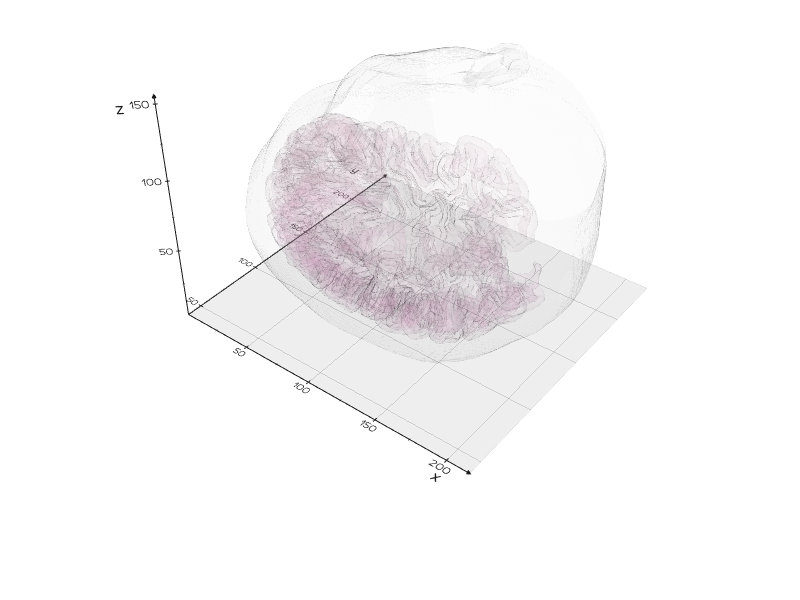

In [7]:
# Plot and show the outer entry zone
actors1 = []
actors1.append(merged_allowed_left_entry_zone)
actors1.append(merged_allowed_right_entry_zone)
actors1.append(merged_skin)
# actors1.append(merged_full_brain)
show(actors1, axes=1, viewup="z", title="Entry Zones")


### Helper Functions

In [8]:
def compute_path_length(start_point, end_point):
    """Compute the distance between two points for the line path."""
    return np.linalg.norm(np.array(end_point) - np.array(start_point))


def compute_obstacle_distance(start_point, end_point):
    """Compute the minimum distance from the line path to any obstacle."""
    if merged_obstacles is None:
        return 0.0
    temp_line = Line([start_point, end_point])
    d = temp_line.distance_to(merged_obstacles)
    if isinstance(d, (list, tuple, np.ndarray)):
        return float(np.min(d))
    return float(d)


def check_intersection(start_point, end_point):
    """Check if the line path intersects any obstacle."""
    if merged_obstacles is None:
        return False
    intersections = merged_obstacles.intersect_with_line(start_point, end_point)
    return intersections is not None and len(intersections) > 0


def _closest_point_on_mesh(point, mesh):
    """Project a 3D point onto the closest point on a mesh surface."""
    if mesh is None:
        return tuple(point)
    try:
        cp = mesh.closest_point(point)
        return tuple(cp)
    except Exception:
        # Fallback to nearest vertex
        verts = np.asarray(mesh.vertices)
        if verts.size == 0:
            return tuple(point)
        idx = int(np.argmin(np.linalg.norm(verts - np.asarray(point), axis=1)))
        return tuple(verts[idx])


def project_to_surfaces(start_point, end_point, hemisphere):
    """Project start onto entry zone then onto skin; end onto STN for hemisphere."""
    # 1. project to entry zone of hemisphere
    if hemisphere == 'left':
        sp_entry = _closest_point_on_mesh(start_point, merged_allowed_left_entry_zone)
        ep = _closest_point_on_mesh(end_point, merged_left_stn)
    else:
        sp_entry = _closest_point_on_mesh(start_point, merged_allowed_right_entry_zone)
        ep = _closest_point_on_mesh(end_point, merged_right_stn)
    # 2. project onto head skin surface
    sp = _closest_point_on_mesh(sp_entry, merged_skin)
    return sp, ep


def sample_start_and_end():
    """Sample a hemisphere-consistent start (entry zone) and end (STN)."""
    hemispheres = []
    if merged_allowed_left_entry_zone and merged_left_stn:
        hemispheres.append('left')
    if merged_allowed_right_entry_zone and merged_right_stn:
        hemispheres.append('right')
    if not hemispheres:
        raise RuntimeError("No valid hemisphere data available for sampling.")
    hemi = random.choice(hemispheres)
    # Sample a random point from entry zone surface, then project to skin
    if hemi == 'left':
        start_entry = tuple(merged_allowed_left_entry_zone.generate_random_points(1).points[0])
        end = tuple(merged_left_stn.generate_random_points(1).points[0])
    else:
        start_entry = tuple(merged_allowed_right_entry_zone.generate_random_points(1).points[0])
        end = tuple(merged_right_stn.generate_random_points(1).points[0])
    start = _closest_point_on_mesh(start_entry, merged_skin)
    return hemi, start, end


## 2. Monte Carlo Optimization

### Path Generation and Optimization

Generate random paths from brain surface to STN and evaluate them:
- **Orange lines**: Failed paths (intersect obstacles)
- **Yellow lines**: Successful but suboptimal paths
- **Green line**: Optimal path (maximum distance from obstacles)

**Optimization Algorithm**

Runs until finding a minimum of `min_successful_attempts`, or up until `max_attempts`.

Chooses a **random location** from the viable brain surface region and the STN of the corresponding hemisphere. 

For each plot, the distance from obstacles is saved. The "best" path is determined using the highest distance to obstacles.

In [31]:
## Config for Monte Carlo
# Monte Carlo path generation parameters
max_attempts = 2000
min_successful_attempts = 100

# Line width configuration (for visualization)
BEST_PATH_WIDTH = 6
SUBOPTIMAL_PATH_WIDTH = 4
FAILED_PATH_WIDTH = 4

In [23]:
## Run Monte Carlo sampling

successful_attempts = []  # Store (hemisphere, start_point, end_point, obstacle_distance, path_length) tuples
failed_attempts = []      # Store (hemisphere, start_point, end_point, obstacle_distance(=0 for fail), path_length)
failed_lines = []

for attempt in range(max_attempts):
    if len(successful_attempts) >= min_successful_attempts:
        break

    hemi, start_point, end_point = sample_start_and_end()
    print(f"Attempt {attempt+1}: hemisphere={hemi} start={start_point} end={end_point}")

    path_len = compute_path_length(start_point, end_point)

    # Check for intersection if we have obstacles
    if merged_obstacles:
        if not check_intersection(start_point, end_point):
            # Compute metrics
            temp_line = Line([start_point, end_point])
            obstacle_dist = compute_obstacle_distance(start_point, end_point)
            successful_attempts.append((hemi, start_point, end_point, obstacle_dist, path_len))
            print(f"  SUCCESS ({len(successful_attempts)}/{min_successful_attempts}) - Obstacle Distance: {obstacle_dist:.3f} Path Length: {path_len:.3f}")
        else:
            failed_line = Line([start_point, end_point]).c("orange").alpha(0.3).lw(FAILED_PATH_WIDTH)
            failed_lines.append(failed_line)
            failed_attempts.append((hemi, start_point, end_point, 0.0, path_len))
            print("  FAIL - Line intersects obstacles")
    else:
        obstacle_dist = 0.0
        successful_attempts.append((hemi, start_point, end_point, obstacle_dist, path_len))
        print(f"  SUCCESS ({len(successful_attempts)}/{min_successful_attempts}) (no obstacles) Path Length: {path_len:.3f}")
else:
    print(f"Warning: Only found {len(successful_attempts)} non-intersecting lines after {max_attempts} attempts")

Attempt 1: hemisphere=left start=(np.float64(39.99916076660156), np.float64(99.0), np.float64(28.500839233398438)) end=(np.float32(106.93339), np.float32(131.10638), np.float32(71.06661))
  SUCCESS (1/100) - Obstacle Distance: 4.684 Path Length: 85.574
Attempt 2: hemisphere=right start=(np.float64(185.75), np.float64(73.5), np.float64(105.0)) end=(np.float32(108.21523), np.float32(129.25), np.float32(84.579254))
  FAIL - Line intersects obstacles
Attempt 3: hemisphere=left start=(np.float64(141.75), np.float64(81.0), np.float64(16.0)) end=(np.float32(107.7616), np.float32(130.12901), np.float32(70.2384))
  FAIL - Line intersects obstacles
Attempt 4: hemisphere=right start=(np.float64(90.0), np.float64(52.0), np.float64(108.75)) end=(np.float32(107.09087), np.float32(130.18729), np.float32(82.312706))
  FAIL - Line intersects obstacles
Attempt 5: hemisphere=left start=(np.float64(123.0), np.float64(55.75), np.float64(39.0)) end=(np.float32(106.66092), np.float32(129.45807), np.float32(7

### Select Optimal Path

Find the best path among successful attempts by maximizing distance from obstacles.

In [32]:
# Select best path (maximum obstacle distance; tie-breaker shorter path length)
SUBOPTIMAL_PATHS_TO_DISPLAY = 10

best_path = None
suboptimal_lines = []
selected_hemisphere = None

if successful_attempts:
    # Sort: first by obstacle distance desc, then by path length asc
    successful_attempts.sort(key=lambda x: (-x[3], x[4]))

    best_hemi, best_start, best_end, best_obstacle_dist, best_path_len = successful_attempts[0]
    best_path = Line([best_start, best_end]).c("green").lw(BEST_PATH_WIDTH)
    selected_hemisphere = best_hemi
    print(f"\nBest path: hemisphere={best_hemi} obstacle_dist={best_obstacle_dist:.3f} path_len={best_path_len:.3f}")

    s = 1
    for hemi, start_pt, end_pt, obstacle_dist, path_len in successful_attempts[1:]:
        if s > SUBOPTIMAL_PATHS_TO_DISPLAY:
            break
        
        suboptimal_line = Line([start_pt, end_pt]).c("yellow").alpha(0.3).lw(SUBOPTIMAL_PATH_WIDTH)
        suboptimal_lines.append(suboptimal_line)
        print(f"Suboptimal path {s}: hemi={hemi} obstacle_dist={obstacle_dist:.3f} path_len={path_len:.3f}")
        
        s += 1
else:
    print("No successful paths found!")

print("\nTotal successful paths: ", len(successful_attempts))


Best path: hemisphere=right obstacle_dist=7.469 path_len=75.688
Suboptimal path 1: hemi=right obstacle_dist=7.180 path_len=66.550
Suboptimal path 2: hemi=right obstacle_dist=7.177 path_len=70.123
Suboptimal path 3: hemi=right obstacle_dist=7.129 path_len=82.038
Suboptimal path 4: hemi=right obstacle_dist=7.077 path_len=84.579
Suboptimal path 5: hemi=right obstacle_dist=7.033 path_len=80.420
Suboptimal path 6: hemi=right obstacle_dist=6.890 path_len=82.026
Suboptimal path 7: hemi=right obstacle_dist=6.766 path_len=70.573
Suboptimal path 8: hemi=right obstacle_dist=6.749 path_len=83.987
Suboptimal path 9: hemi=right obstacle_dist=6.728 path_len=72.199
Suboptimal path 10: hemi=right obstacle_dist=6.723 path_len=88.658

Total successful paths:  100


In [33]:
## Save Monte Carlo path coordinates to file (success + fail + best flag)
output_file = "monte_carlo_paths.csv"
with open(output_file, 'w') as f:
    f.write("hemisphere,start_x,start_y,start_z,end_x,end_y,end_z,obstacle_distance,path_length,status,is_best\n")
    # Successful attempts are already sorted (best first) after selection step
    for idx, (hemi, start_pt, end_pt, obstacle_dist, path_len) in enumerate(successful_attempts):
        is_best = 1 if idx == 0 else 0
        f.write(
            f"{hemi},{start_pt[0]},{start_pt[1]},{start_pt[2]},{end_pt[0]},{end_pt[1]},{end_pt[2]},{obstacle_dist},{path_len},success,{is_best}\n"
        )
    # Failed attempts
    for hemi, start_pt, end_pt, obstacle_dist, path_len in failed_attempts:
        f.write(
            f"{hemi},{start_pt[0]},{start_pt[1]},{start_pt[2]},{end_pt[0]},{end_pt[1]},{end_pt[2]},{obstacle_dist},{path_len},fail,0\n"
        )
print(f"Saved Monte Carlo paths ({len(successful_attempts)} success, {len(failed_attempts)} fail) to {output_file}")

Saved Monte Carlo paths (100 success, 48 fail) to monte_carlo_paths.csv


## 3. Weighted Sum + Mono-Criteria Optimization

### Configuration

Set weights and optimization parameters:
- `w_obstacle`: Weight for obstacle distance (maximize)
- `w_path_length`: Weight for path length (minimize)
- Weights are normalized automatically
- `n_initial`: Number of best Monte Carlo paths to use as initial conditions

In [ ]:
# Weights for multi-objective optimization (easily configurable)
w_obstacle = 0.9     # Weight for obstacle distance (higher = prefer safer paths)
w_path_length = 0.1   # Weight for path length (higher = prefer shorter paths)

# Normalize weights to sum to 1
total_weight = w_obstacle + w_path_length
w_obstacle_norm = w_obstacle / total_weight
w_path_length_norm = w_path_length / total_weight

print(f"Objective function weights:\n  Obstacle distance: {w_obstacle_norm:.3f}\n  Path length: {w_path_length_norm:.3f}")

# Mono-criteria optimization parameters
initial_point_attempts = 50
nm_max_iterations = 500
nm_tolerance = 1e-6  # default: 1e-6, applied as xatol and fatol

# Hemisphere lock for optimization (set later when picking x0)
nm_hemisphere = None

# Number of best Monte Carlo paths to use as initial conditions
n_initial = 10

Objective function weights:
  Obstacle distance: 0.900
  Path length: 0.100


### Weighted Sum Objective Function

Combines both objectives (obstacle distance and path length) into a single scalar value for optimization.

In [15]:
# Global variables for normalization (will be computed from sample paths)
max_obstacle_dist = None
max_path_length = None

def weighted_sum_objective(x):
    """
    Weighted sum objective function for optimization.

    Parameters:
    -----------
    x : array-like, shape (6,)
        [start_x, start_y, start_z, end_x, end_y, end_z]

    Returns:
    --------
    float : Objective value (to be minimized)
    """
    global nm_hemisphere
    start_guess = tuple(x[:3])
    end_guess = tuple(x[3:])

    # If hemisphere not set, infer a reasonable default
    if nm_hemisphere is None:
        nm_hemisphere = 'left' if merged_left_entry_zone and merged_left_stn else 'right'

    # Project guesses to valid surfaces for the locked hemisphere
    start_point, end_point = project_to_surfaces(start_guess, end_guess, nm_hemisphere)

    # Hard constraint: penalize intersection
    if check_intersection(start_point, end_point):
        return 1e10

    # Compute objectives
    obstacle_dist = compute_obstacle_distance(start_point, end_point)
    path_length = compute_path_length(start_point, end_point)

    # Normalize objectives
    if max_obstacle_dist is not None and max_obstacle_dist > 0:
        norm_obstacle_dist = obstacle_dist / max_obstacle_dist
    else:
        norm_obstacle_dist = obstacle_dist / 8

    if max_path_length is not None and max_path_length > 0:
        norm_path_length = path_length / max_path_length
    else:
        norm_path_length = path_length / 105

    # Weighted sum: minimize (-obstacle_dist) and minimize path_length
    objective = -w_obstacle_norm * norm_obstacle_dist + w_path_length_norm * norm_path_length
    return objective

### Estimate Normalization Constants

Sample a few random paths to estimate typical ranges for obstacle distance and path length.

In [33]:
# ## OPTION 1 - Sample random paths to estimate normalization constants
# ESTIMATION_SAMPLES = 100

# print("Estimating normalization constants from random samples...")
# sample_obstacle_dists = []
# sample_path_lengths = []

# for _ in range(ESTIMATION_SAMPLES):
#     print(f"Sampling path {_+1}/{ESTIMATION_SAMPLES}...")
#     hemi, start, end = sample_start_and_end()
#     if not check_intersection(start, end):
#         obstacle_dist = compute_obstacle_distance(start, end)
#         path_length = compute_path_length(start, end)
#         sample_obstacle_dists.append(obstacle_dist)
#         sample_path_lengths.append(path_length)
#         # print(f"  obstacle_dist={obstacle_dist:.3f} path_len={path_length:.3f}")
#     else:
#         print("  Sampled path intersects obstacles, skipping...")

# if sample_obstacle_dists:
#     max_obstacle_dist = max(sample_obstacle_dists)
#     max_path_length = max(sample_path_lengths)
#     print(f"Estimated max obstacle distance: {max_obstacle_dist:.2f}")
#     print(f"Estimated max path length: {max_path_length:.2f}")
# else:
#     print("Warning: No valid paths found for normalization, using defaults")
#     max_obstacle_dist = 8
#     max_path_length = 100


In [ ]:
# ## OPTION 2: Use Monte Carlo results for normalization (if available)
# if successful_attempts:
#     print("\nUsing Monte Carlo results for normalization...")
#     mc_obstacle_dists = [x[3] for x in successful_attempts]
#     mc_path_lengths = [x[4] for x in successful_attempts]
#     max_obstacle_dist = max(mc_obstacle_dists)
#     max_path_length = max(mc_path_lengths)
#     print(f"Max obstacle distance from Monte Carlo: {max_obstacle_dist:.2f}")
#     print(f"Max path length from Monte Carlo: {max_path_length:.2f}")
# else:
#     print("\nNo Monte Carlo results available for normalization, using defaults")
#     max_obstacle_dist = 8
#     max_path_length = 105



Using Monte Carlo results for normalization...
Max obstacle distance from Monte Carlo: 7.47
Max path length from Monte Carlo: 104.96


In [25]:
## OPTION 3: Use fixed defaults
max_obstacle_dist = 8
max_path_length = 105

### Set Initial Path for Optimization 

Also select a configurable number of best Monte Carlo paths as initial conditions (`initial_paths`).

In [35]:
# ## OPTION 1: Find first n_initial feasible initial points from random sampling
# print("\nFinding feasible initial points...")
# initial_paths = []  # list of tuples (hemi, start, end, obstacle_dist, path_len)
# attempts = 0
# while len(initial_paths) < n_initial and attempts < initial_point_attempts:
#     hemi, start, end = sample_start_and_end()
#     attempts += 1
#     if not check_intersection(start, end):
#         path_len = compute_path_length(start, end)
#         obstacle_dist = compute_obstacle_distance(start, end)
#         initial_paths.append((hemi, start, end, obstacle_dist, path_len))
#         print(f"  Feasible {len(initial_paths)}/{n_initial}: hemi={hemi} obstacle={obstacle_dist:.3f} length={path_len:.3f}")
#     else:
#         print("  Sampled path intersects obstacles, skipping...")

# if not initial_paths:
#     print("Warning: Could not find any feasible starting points; will fall back to Monte Carlo best if available.")

In [17]:
## OPTION 2: Select best Monte Carlo path(s) as starting point(s)
if successful_attempts:
    print("\nSelecting initial conditions from best Monte Carlo paths...")
    # successful_attempts is already sorted earlier (best first)
    take = min(n_initial, len(successful_attempts))
    initial_paths = successful_attempts[:take]
    
    print(f"  Using {take} initial path(s) from Monte Carlo results")
    
    # Ensure initial_paths are not all from the same hemisphere
    hemis = [h for h, *_ in initial_paths[:take]]
    
    if len(set(hemis)) == 1:
        target_hemi = 'left' if hemis[0] == 'right' else 'right'
        print(f"  Detected single-hemisphere initials ({hemis[0]}). Picking one from {target_hemi} hemi in successful_attempts...")

        # Find first successful attempt from the opposite hemisphere beyond the first 'take'
        replacement = next((rec for rec in successful_attempts[take:] if rec[0] == target_hemi), None)

        if replacement:
            initial_paths[-1] = replacement
            print("  Replaced one initial path with other-hemisphere entry from successful_attempts.")
        else:
            print("  Warning: No other-hemisphere entry found in successful_attempts; keeping originals.")
    # Update selected hemisphere preview from the first initial path
    selected_hemisphere = initial_paths[0][0]
else:
    raise RuntimeError("No successful Monte Carlo paths available for optimization initialization.")


Selecting initial conditions from best Monte Carlo paths...
  Using 10 initial path(s) from Monte Carlo results
  Detected single-hemisphere initials (right). Picking one from left hemi in successful_attempts...
  Replaced one initial path with other-hemisphere entry from successful_attempts.


### Mono-criteria optimization function

Function to optimize with multiple initial conditions given a specific method.

Methods: Nelder-Mead, Powell, or Cobyla.

In [23]:
import time

def run_multistart(method_name, options):
    """Run chosen optimization method over all initial_paths and return best record.

    Returns:
      best_record, records_list
    Prints per-start info plus total elapsed time and summed iterations across starts.
    """
    if not initial_paths:
        raise RuntimeError("initial_paths is empty. Ensure Monte Carlo step ran and initial paths were selected.")

    best = None
    records = []
    total_time = 0.0
    total_iterations = 0

    for idx, (hemi, start, end, obst, plen) in enumerate(initial_paths, start=1):
        print(f"\n[{method_name} {idx}/{len(initial_paths)}] hemi={hemi}")
        global nm_hemisphere
        nm_hemisphere = hemi  # hemisphere locking
        x0 = np.concatenate([start, end])
        t0 = time.perf_counter()
        res = minimize(weighted_sum_objective, x0, method=method_name, options=options)
        elapsed = time.perf_counter() - t0
        iters = getattr(res, 'nit', getattr(res, 'nfev', 0)) or 0
        total_time += elapsed
        total_iterations += iters

        raw_start = tuple(res.x[:3])
        raw_end = tuple(res.x[3:])
        opt_start, opt_end = project_to_surfaces(raw_start, raw_end, nm_hemisphere)
        opt_obj = float(res.fun)
        opt_obst = compute_obstacle_distance(opt_start, opt_end)
        opt_len = compute_path_length(opt_start, opt_end)
        opt_line = Line([opt_start, opt_end]).c("cyan").lw(10) if method_name == 'Nelder-Mead' else Line([opt_start, opt_end]).c("magenta" if method_name=='Powell' else "blue").lw(10)

        rec = {
            'method': method_name,
            'hemi': hemi,
            'start': opt_start,
            'end': opt_end,
            'objective': opt_obj,
            'obstacle_distance': opt_obst,
            'path_length': opt_len,
            'line': opt_line,
            'result': res,
            'elapsed': elapsed,
            'iterations': iters
        }
        records.append(rec)
        if best is None or opt_obj < best['objective']:
            best = rec
        print(f"  Objective: {opt_obj:.6f}  ObstDist: {opt_obst:.3f}  PathLen: {opt_len:.3f}")
        print(f"  Elapsed: {elapsed:.3f}s  Iterations: {iters}")

    print(f"\n[{method_name} Summary] Total time: {total_time:.3f}s  Total iterations: {total_iterations}")
    return best, records

## Load Path Data

In [9]:
import csv

In [10]:
## Load Monte Carlo path coordinates from file
input_file = "monte_carlo_paths.csv"
monte_carlo_records = []

if os.path.exists(input_file):
    with open(input_file, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            try:
                record = {
                    'hemisphere': row['hemisphere'],
                    'start': (
                        float(row['start_x']),
                        float(row['start_y']),
                        float(row['start_z'])
                    ),
                    'end': (
                        float(row['end_x']),
                        float(row['end_y']),
                        float(row['end_z'])
                    ),
                    'obstacle_distance': float(row['obstacle_distance']),
                    'path_length': float(row['path_length']),
                    'status': row['status'],
                    'is_best': (row.get('is_best', '0') == '1')
                }
                monte_carlo_records.append(record)
            except Exception as e:
                print(f"[WARN] Skipping row due to parse error: {e}")

    # Rebuild successful_attempts if empty (avoid overwriting if already present)
    if 'successful_attempts' not in globals():
        successful_attempts = []
    if not successful_attempts:
        for r in monte_carlo_records:
            if r['status'] == 'success':
                successful_attempts.append((r['hemisphere'], r['start'], r['end'], r['obstacle_distance'], r['path_length']))

    # Rebuild failed_attempts if empty
    if 'failed_attempts' not in globals():
        failed_attempts = []
    if not failed_attempts:
        for r in monte_carlo_records:
            if r['status'] == 'fail':
                failed_attempts.append((r['hemisphere'], r['start'], r['end'], r['obstacle_distance'], r['path_length']))

    # Identify best path
    loaded_best = next((r for r in monte_carlo_records if r['status'] == 'success' and r['is_best']), None)
    if loaded_best:
        print(f"Loaded best Monte Carlo path: hemi={loaded_best['hemisphere']} obstacle_dist={loaded_best['obstacle_distance']:.3f} path_len={loaded_best['path_length']:.3f}")
    else:
        print("Best Monte Carlo path flag not found; will infer later if needed.")
    print(f"Loaded {len(monte_carlo_records)} Monte Carlo path records from {input_file}")
else:
    print(f"[INFO] Monte Carlo path file not found: {input_file}")

Loaded best Monte Carlo path: hemi=right obstacle_dist=7.469 path_len=75.688
Loaded 148 Monte Carlo path records from monte_carlo_paths.csv


In [ ]:
## Load optimized COBYLA path from file
cobyla_input_file = "cobyla_optimal_path.csv"
# Read COBYLA optimal path from CSV and rebuild variables
if os.path.exists(cobyla_input_file):
    with open(cobyla_input_file, 'r') as f:
        reader = csv.DictReader(f)
        row = next(reader, None)
        if row:
            cobyla_hemisphere = row['hemisphere']
            cobyla_optimal_start = (float(row['start_x']), float(row['start_y']), float(row['start_z']))
            cobyla_optimal_end = (float(row['end_x']), float(row['end_y']), float(row['end_z']))
            cobyla_obstacle_dist = float(row['obstacle_distance'])
            cobyla_path_length = float(row['path_length'])
            cobyla_weighted_obj = float(row.get('weighted_objective', -w_obstacle_norm * (cobyla_obstacle_dist / max_obstacle_dist if max_obstacle_dist else cobyla_obstacle_dist / 100.0)
                                            + w_path_length_norm * (cobyla_path_length / max_path_length if max_path_length else cobyla_path_length / 200.0)))
            selected_hemisphere = cobyla_hemisphere
            cobyla_optimal_line = Line([cobyla_optimal_start, cobyla_optimal_end]).c("blue").lw(10)
            print(f"Loaded COBYLA path: hemi={cobyla_hemisphere} obstacle={cobyla_obstacle_dist:.3f} length={cobyla_path_length:.3f} weighted={cobyla_weighted_obj:.6f}")
        else:
            print("[INFO] COBYLA file is empty.")
else:
    print(f"[INFO] COBYLA path file not found: {cobyla_input_file}")

Loaded COBYLA path: hemi=right obstacle=7.649 length=65.863 weighted=-0.858854


## Pareto Front Optimization

In [60]:
## Config and Setup
# Set weight combinations for Pareto sweep
weights = [
    {"w_obstacle": 0.95, "w_path_length": 0.05},
    {"w_obstacle": 0.90, "w_path_length": 0.10},
    {"w_obstacle": 0.85, "w_path_length": 0.15},
    {"w_obstacle": 0.80, "w_path_length": 0.20},
    {"w_obstacle": 0.75, "w_path_length": 0.25},
    {"w_obstacle": 0.70, "w_path_length": 0.30},
    {"w_obstacle": 0.65, "w_path_length": 0.35},
    {"w_obstacle": 0.60, "w_path_length": 0.40},
    {"w_obstacle": 0.55, "w_path_length": 0.45},
]


# Select optimization method for Pareto runs
opt_method = 'COBYLA'  # Options: 'COBYLA', 'Nelder-Mead', 'Powell'


# Storage for Pareto-optimal results
pareto_results = []  # list of dicts with method, weights, hemisphere, start, end, metrics
pareto_lines = []    # list of vedo.Line for plotting

In [61]:
# (Optional) Load existing COBYLA result as Pareto entry (0.90, 0.10)
try:
    # If previously loaded, these variables exist from the CSV loader cell
    if 'cobyla_optimal_start' in globals() and 'cobyla_optimal_end' in globals():
        preload_weights = (0.90, 0.10)
        if any(abs(w['w_obstacle']-preload_weights[0])<1e-9 and abs(w['w_path_length']-preload_weights[1])<1e-9 for w in weights):
            rec = {
                'method': 'COBYLA',
                'w_obstacle': preload_weights[0],
                'w_path_length': preload_weights[1],
                'hemisphere': cobyla_hemisphere,
                'start': cobyla_optimal_start,
                'end': cobyla_optimal_end,
                'weighted_objective': -w_obstacle_norm * (cobyla_obstacle_dist / max_obstacle_dist) + w_path_length_norm * (cobyla_path_length / max_path_length) if (max_obstacle_dist and max_path_length) else None,
                'obstacle_distance': cobyla_obstacle_dist,
                'path_length': cobyla_path_length
            }
            pareto_results.append(rec)
            # Create a line if not already present
            line_color = 'blue'
            preload_line = Line([cobyla_optimal_start, cobyla_optimal_end]).c(line_color).lw(10)
            pareto_lines.append(preload_line)
            print("Preloaded COBYLA Pareto entry for weights (0.90, 0.10) from CSV.")
    else:
        print("COBYLA CSV variables not loaded; skipping preload.")
except Exception as e:
    print(f"[WARN] Failed to preload COBYLA Pareto entry: {e}")

Preloaded COBYLA Pareto entry for weights (0.90, 0.10) from CSV.


In [62]:
for w in weights:
    # Weights for multi-objective optimization
    w_obstacle = w["w_obstacle"]
    w_path_length = w["w_path_length"]
    
    # Normalize weights to sum to 1
    total_weight = w_obstacle + w_path_length
    w_obstacle_norm = w_obstacle / total_weight
    w_path_length_norm = w_path_length / total_weight
    
    if any(abs(r['w_obstacle']-w_obstacle_norm)<1e-9 and abs(r['w_path_length']-w_path_length_norm)<1e-9 for r in pareto_results):
        print(f"\nSkipping weights w_obstacle={w_obstacle_norm:.2f}, w_path_length={w_path_length_norm:.2f} (already computed)")
        continue
    
    print(f"Objective function weights:\n  Obstacle distance: {w_obstacle_norm:.3f}\n  Path length: {w_path_length_norm:.3f}")
    
    print(f"\nRunning {opt_method} optimization over {len(initial_paths)} initial path(s)...")
    best_run, all_records = run_multistart(opt_method, {
        'maxiter': nm_max_iterations,
        'tol': nm_tolerance,
        'disp': True
    })
    
    hemi = best_run['hemi']
    opt_start = best_run['start']
    opt_end = best_run['end']
    opt_objective = best_run['objective']
    opt_obst = best_run['obstacle_distance']
    opt_len = best_run['path_length']
    opt_line = best_run['line']
    
    pareto_entry = {
        'method': opt_method,
        'w_obstacle': w_obstacle_norm,
        'w_path_length': w_path_length_norm,
        'hemisphere': hemi,
        'start': opt_start,
        'end': opt_end,
        'weighted_objective': opt_objective,
        'obstacle_distance': opt_obst,
        'path_length': opt_len
    }
    pareto_results.append(pareto_entry)
    pareto_lines.append(opt_line)
    
    print(f"\n{'='*60}")
    print(f"Best {opt_method} run for weights w_obstacle={w_obstacle_norm:.2f}, w_path_length={w_path_length_norm:.2f}:")
    print(f"  Hemisphere: {hemi}")
    print(f"  Objective: {opt_objective:.6f}")
    print(f"  Obstacle distance: {opt_obst:.3f}")
    print(f"  Path length: {opt_len:.3f}")
    print(f"  Start: {opt_start}")
    print(f"  End:   {opt_end}")
    
pareto_results.sort(key=lambda x: x['w_obstacle'], reverse=True)

Objective function weights:
  Obstacle distance: 0.950
  Path length: 0.050

Running COBYLA optimization over 10 initial path(s)...

[COBYLA 1/10] hemi=right
Return from COBYLA because the trust region radius reaches its lower bound.
Number of function values = 51   Least value of F = -0.8723686611179942
The corresponding X is:
[131.93378973  99.11454337 151.7226686  107.01089155 129.87629256
  88.48219855]

  Objective: -0.872369  ObstDist: 7.649  PathLen: 75.378
  Elapsed: 1.367s  Iterations: 51

[COBYLA 2/10] hemi=right
Return from COBYLA because the trust region radius reaches its lower bound.
Number of function values = 51   Least value of F = -0.8768992817157146
The corresponding X is:
[ 89.87287812 118.56192489 150.0118239  107.92718496 131.19793002
  88.28109638]

  Objective: -0.876899  ObstDist: 7.649  PathLen: 65.863
  Elapsed: 1.289s  Iterations: 51

[COBYLA 3/10] hemi=right
Return from COBYLA because the trust region radius reaches its lower bound.
Number of function value

In [50]:
# Save aggregated Pareto-optimal paths to CSV
pareto_output_file = 'linear_pareto_optimal_paths.csv'
with open(pareto_output_file, 'w') as f:
    f.write('method,w_obstacle,w_path_length,hemisphere,start_x,start_y,start_z,end_x,end_y,end_z,obstacle_distance,path_length,weighted_objective\n')
    for rec in pareto_results:
        sx, sy, sz = rec['start']
        ex, ey, ez = rec['end']
        f.write(
            f"{rec['method']},{rec['w_obstacle']},{rec['w_path_length']},{rec['hemisphere']},{sx},{sy},{sz},{ex},{ey},{ez},{rec['obstacle_distance']},{rec['path_length']},{rec['weighted_objective']}\n"
        )
print(f'Saved Pareto-optimal set ({len(pareto_results)} paths) to {pareto_output_file}')

Saved Pareto-optimal set (9 paths) to linear_pareto_optimal_paths.csv


## Visualization

In [51]:
# Set vedo backend to pop out plots in separate windows
vedo.settings.default_backend = 'vtk' # or 'vt' or '2d' or 'k3d' or 'ipyvtklink'

In [57]:
## Plot final results
# NUM_FAILED_TO_SHOW = min(10, len(failed_lines))
NUM_SUBOPTIMAL_TO_SHOW = min(10, len(suboptimal_lines))

actors = []
if merged_full_brain: actors.append(merged_full_brain)
if merged_skin: actors.append(merged_skin)

# Hemisphere emphasis based on last selected
if selected_hemisphere == 'left':
    if merged_left_entry_zone: actors.append(merged_left_entry_zone.clone().alpha(0.08))
    if merged_right_entry_zone: actors.append(merged_right_entry_zone.clone().alpha(0.02))
    if merged_left_stn: actors.append(merged_left_stn.clone().alpha(0.9))
    if merged_right_stn: actors.append(merged_right_stn.clone().alpha(0.3))
elif selected_hemisphere == 'right':
    if merged_left_entry_zone: actors.append(merged_left_entry_zone.clone().alpha(0.02))
    if merged_right_entry_zone: actors.append(merged_right_entry_zone.clone().alpha(0.08))
    if merged_left_stn: actors.append(merged_left_stn.clone().alpha(0.3))
    if merged_right_stn: actors.append(merged_right_stn.clone().alpha(0.9))
else:
    if merged_left_entry_zone: actors.append(merged_left_entry_zone)
    if merged_right_entry_zone: actors.append(merged_right_entry_zone)
    if merged_left_stn: actors.append(merged_left_stn)
    if merged_right_stn: actors.append(merged_right_stn)

if merged_obstacles: actors.append(merged_obstacles.clone().alpha(0.7))

# Monte Carlo context
# actors.extend(failed_lines[:NUM_FAILED_TO_SHOW])
actors.extend(suboptimal_lines[:NUM_SUBOPTIMAL_TO_SHOW])
if best_path:
    mc_best_faded = best_path.clone().alpha(0.6).lw(4)
    actors.append(mc_best_faded)

# # Add individual method-optimal paths if present
# try: actors.append(nm_optimal_line)
# except: print("Nelder-Mead optimized path not found.")
# try: actors.append(powell_optimal_line)
# except: print("Powell optimized path not found.")
# try: actors.append(cobyla_optimal_line)
# except: print("Cobyla optimized path not found.")

# Plot Pareto-optimal set together
if 'pareto_lines' in globals() and pareto_lines:
    print(f"Adding {len(pareto_lines)} Pareto-optimal paths to plot...")
    # style them uniformly but slightly transparent to compare
    for i, ln in enumerate(pareto_lines):
        shade = max(0.2, 1 - 0.06 * i)
        color = (shade/2, shade/2, shade)
        actors.append(ln.clone().lw(5).c(color))
else:
    print("No Pareto-optimal paths available to plot.")

print("Rendering scene with Pareto-optimal set...")
show(actors, axes=1, viewup="z", title="Pareto-Optimal Paths", new=True, interactive=True)

Adding 9 Pareto-optimal paths to plot...
Rendering scene with Pareto-optimal set...
